In [1]:
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import sys
sys.path.append('../')
import ABIDEParser as Reader
import utils
import plotting
import os

## Sparsity of adjacency matrix?

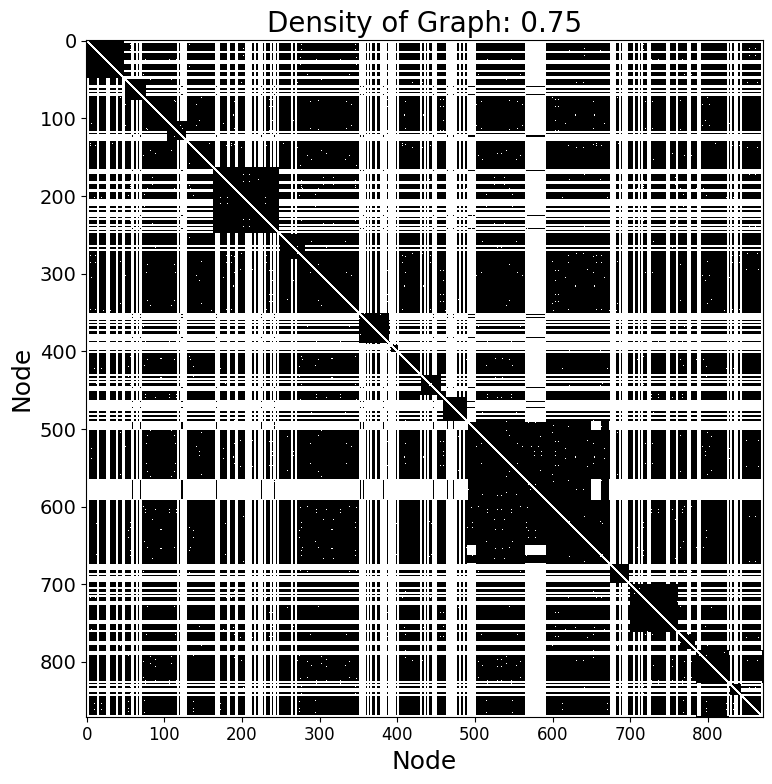

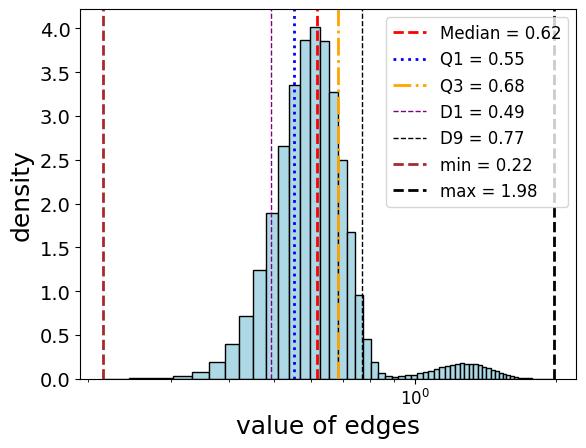

In [2]:
folder_name = '../results/AdjMaExp/AdjMatr_pheno_classic_simi_classic_nbfeats_2000_SimMeth_expo_threshold_SimThre_0_SimTopk_10/'
graph_pheno = np.load(folder_name + 'phenotypic_graph.npy')
graph_features_simi = np.load(folder_name + 'feature_similarity_graph.npy')
graph_adj_matrix = np.load(folder_name + 'adj_matrix.npy')

# Example usage
matrix = graph_adj_matrix 
plotting.plot_adjacency_matrix(matrix, threshold=10**-16)
plotting.plot_histo_nonzero_edges_value(graph_adj_matrix)


## Construction of the adjacency matrix

In [3]:
# folder_name = '../results/AdjMaExp/AdjMatr_pheno_classic_simi_classic_nbfeats_2000_SimMeth_expo_threshold_SimThre_0_SimTopk_10/'
# graph_pheno = np.load(folder_name + 'phenotypic_graph.npy')
# graph_features_simi = np.load(folder_name + 'feature_similarity_graph.npy')
# graph_adj_matrix = np.load(folder_name + 'adj_matrix.npy')
# dic = plotting.build_dic_for_plot_summary_adj_matrix_construction(graph_pheno, graph_features_simi, graph_adj_matrix)
# plotting.plot_summary_adj_matrix_construction(dic)

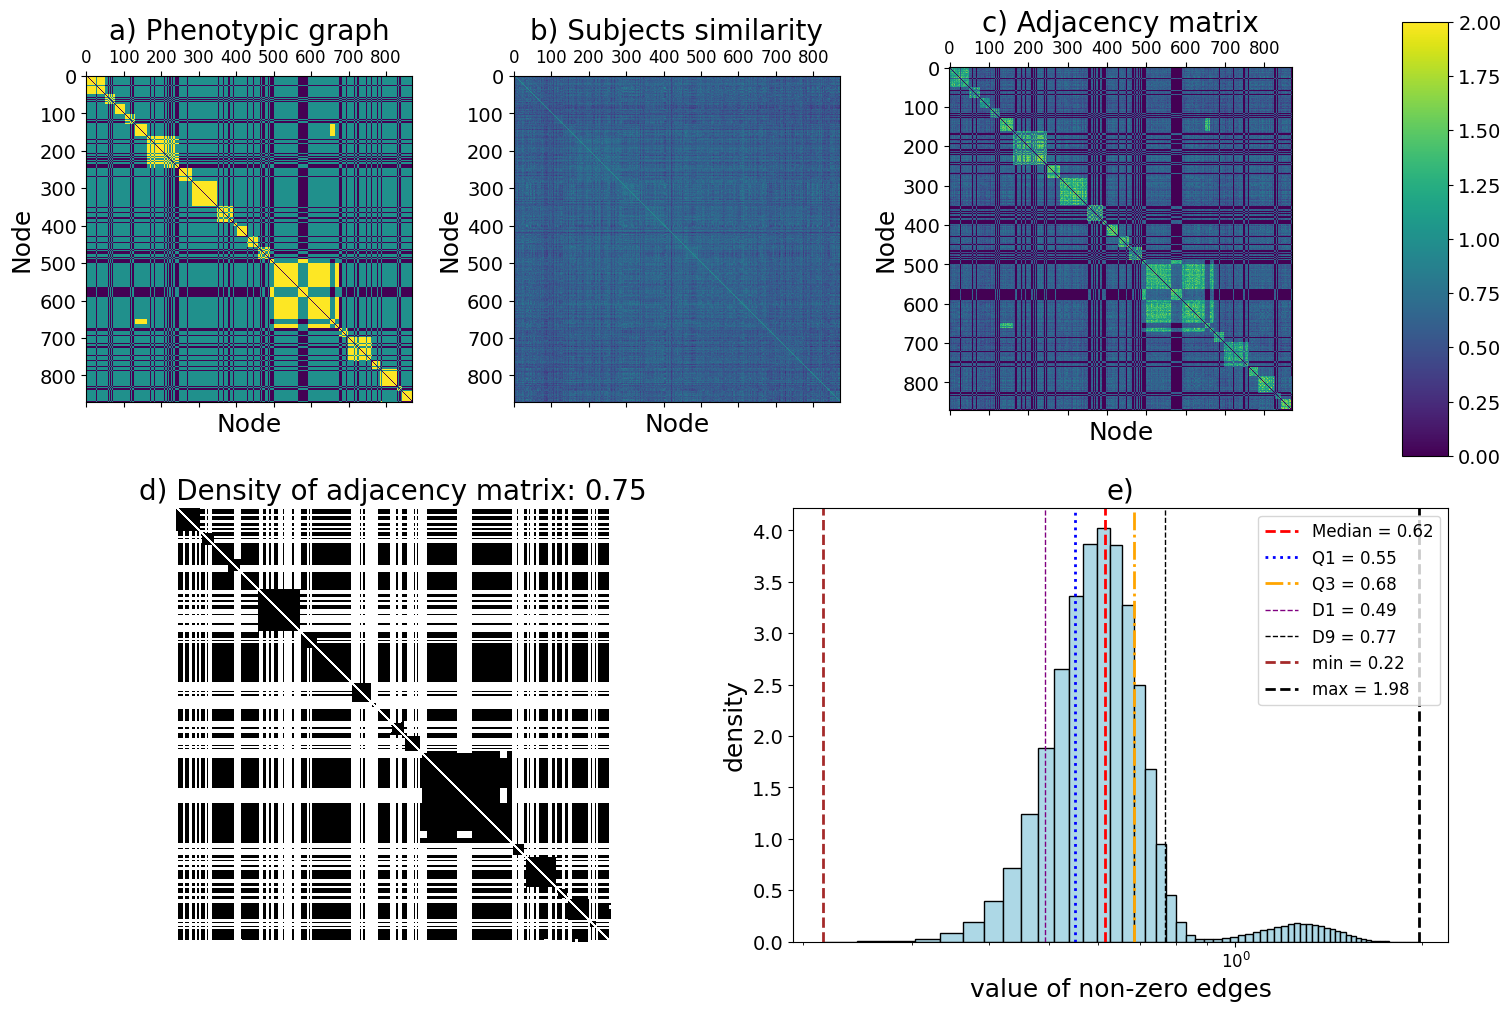

In [4]:
dic = plotting.build_dic_for_plot_summary_adj_matrix_construction(graph_pheno, graph_features_simi, graph_adj_matrix)
plotting.plot_mosaic_adj_matrix(dic)

## Sensitivity of GCN model wrt. adjacency matrix

#### plot the different adjacency matrices

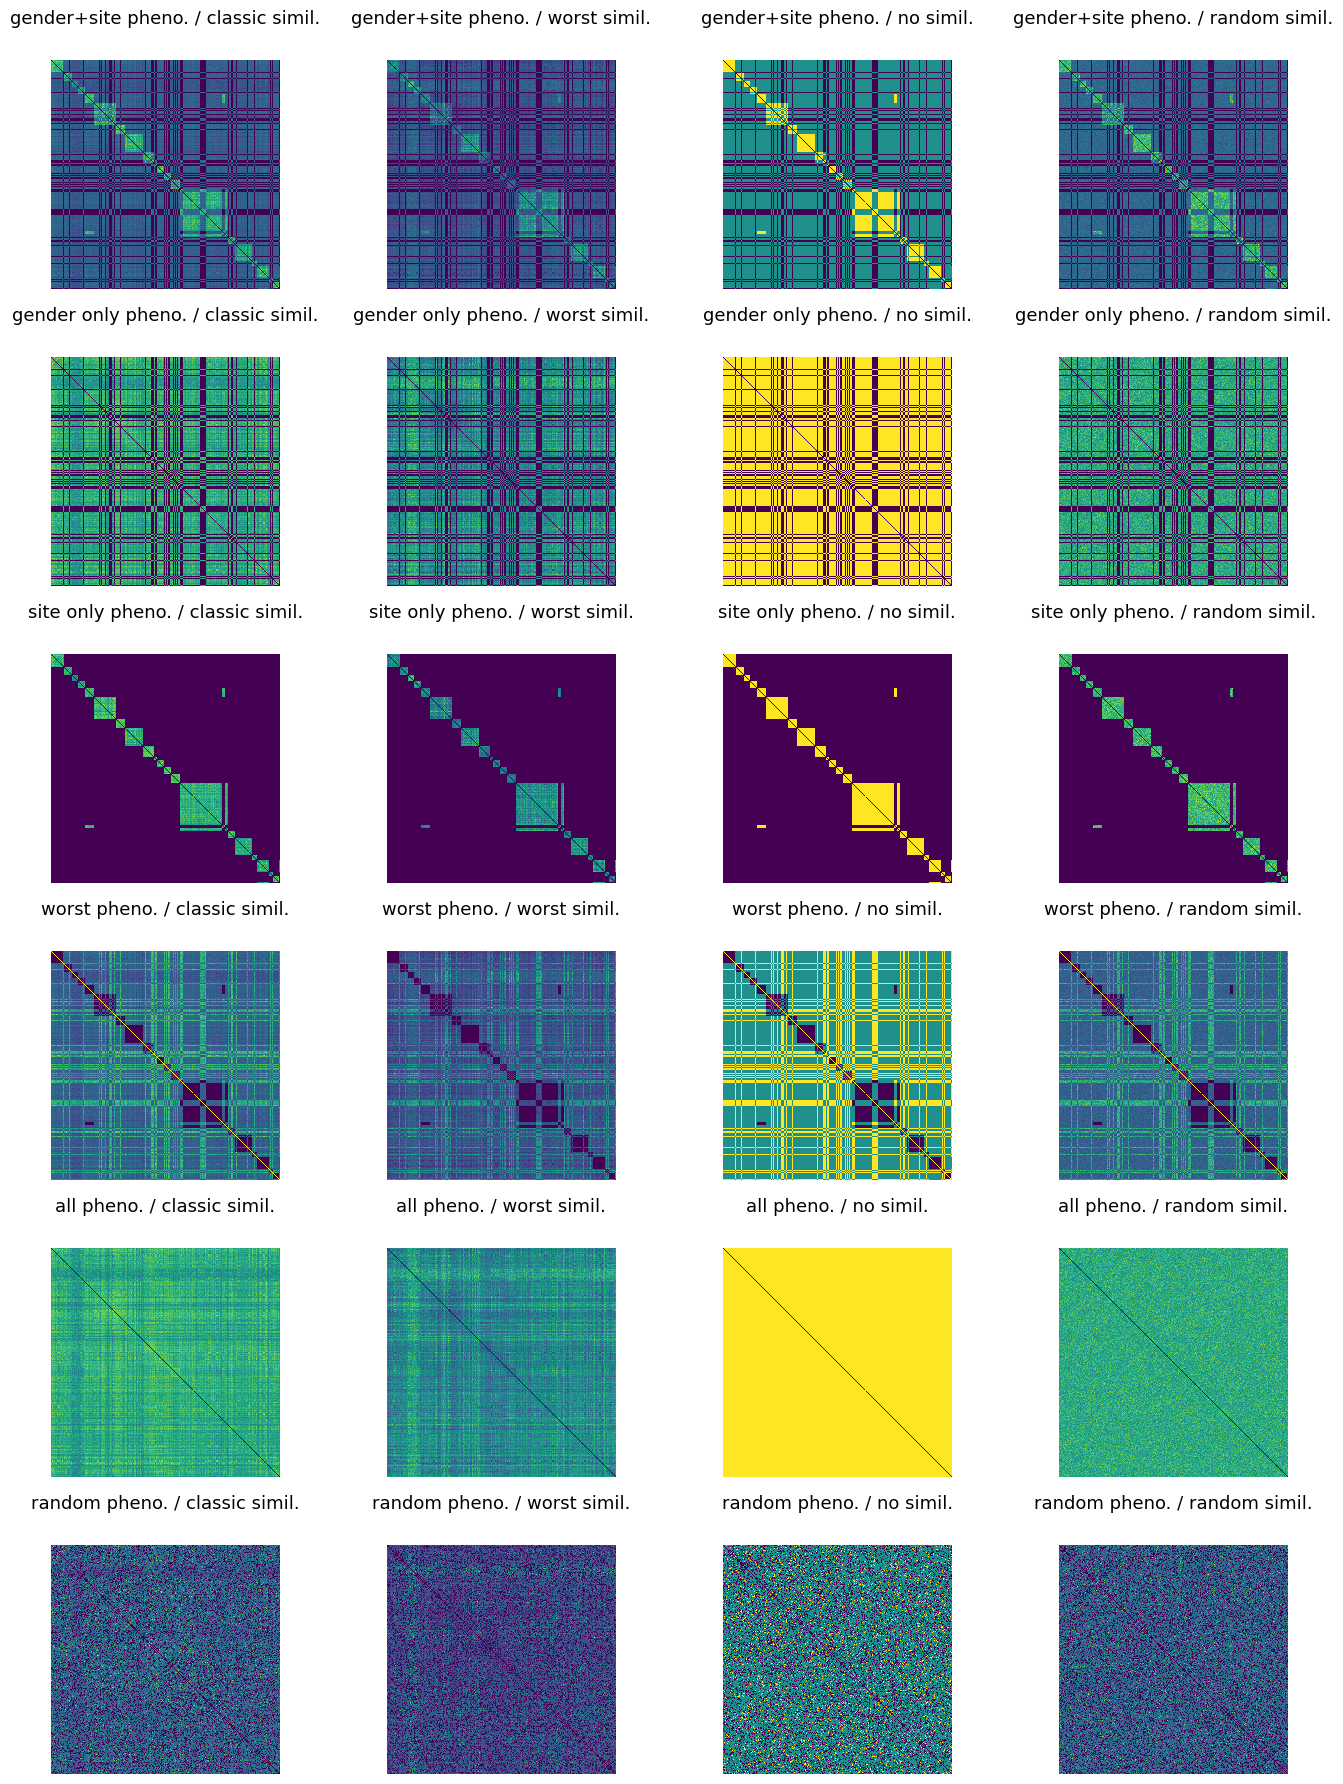

In [5]:
import os 

def get_key_from_folder_name(subfolder):
    params = subfolder.split('_')
    pheno_id = params[params.index('pheno')+1]
    simi_id = params[params.index('simi')+ 1]
    key = f'pheno_{pheno_id}_simi_{simi_id}'
    return key

# Chemin du dossier parent
folder = "../results/AdjMaExp/"

adj_matrix_dic = {}
label_name = []
for subfolder_name in os.listdir(folder):
    complete_path = os.path.join(folder, subfolder_name)
    if os.path.isdir(complete_path):  # Vérifie si c'est un sous-dossier
        if subfolder_name.split('_')[0] == 'AdjMatr':
            key_subfolder = get_key_from_folder_name(subfolder_name)
            adj_matrix = np.load(complete_path + '/adj_matrix.npy')
            label_name.append(key_subfolder)
            adj_matrix_dic[key_subfolder] = adj_matrix


cols_name = ['classic', 'worst', '1', 'random']
cols_labels_name = ['classic', 'worst', 'no', 'random']
rows_name = ['classic', 'G', 'As', 'worst', 'all', 'random']
rows_labels_name = ['gender+site', 'gender only', 'site only', 'worst', 'all', 'random']

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(14, 18),
                        subplot_kw={'xticks': [], 'yticks': []})

for k, row in enumerate(rows_name):
    for l, col in enumerate(cols_name): 
        col_labels_name = cols_labels_name[l]
        row_labels_name = rows_labels_name[k]
        axs[k,l].set_title(f"{row_labels_name} pheno. / {col_labels_name} simil.", fontsize =13)
        # axs[k,l].set_title(f"{row_labels_name} / {row_labels_name}", fontsize =12)
        graph = adj_matrix_dic[f'pheno_{row}_simi_{col}']
        axs[k,l].matshow(graph, cmap="viridis")  
        # axs[k,l].colorbar()
        axs[k,l].axis('off')
        axs[k,l].set_xlabel("Node")
        axs[k,l].set_ylabel("Node")

plt.tight_layout()
plt.savefig('../figures/all_adj_matrices.pdf', dpi=250)
plt.savefig('../figures/all_adj_matrices.png', dpi=250)

#### Study of the accuracy wrt. graph support

In [6]:
def get_key_from_folder_name(subfolder):
    params = subfolder.split('_')
    pheno_id = params[params.index('pheno')+1]
    simi_id = params[params.index('simi')+ 1]
    seedInit_id = None if 'seed' not in params else params[params.index('seed')+ 1]
    seedFold_id = None if 'seedF' not in params else params[params.index('seedF')+ 1]
    key = f'pheno_{pheno_id}_simi_{simi_id}_seedInit_{seedInit_id}_seedFold_{seedFold_id}'
    label = f'pheno_{pheno_id}_simi_{simi_id}'
    return key, label

def average_several_dfs(dfs_list):
    df = dfs_list[0].copy()
    for k in range(1,len(dfs_list)):
        for col in ['ridge_classifier_acc',	"ridge_classifier_auc",	"GCN_acc",	"GCN_auc"]:
            df[col] += dfs_list[k][col]
            
    for col in ['ridge_classifier_acc',	"ridge_classifier_auc",	"GCN_acc",	"GCN_auc"]:
        df[col] /= len(dfs_list)
    return df

def average_results_wrt_seed_init(labels, dfs_dic):
    dfs_dic_average = {}
    for label in labels:
        list_keys = [element for element in dfs_dic.keys() if label in element]
        dfs_list_for_label = [dfs_dic[key] for key in list_keys]
        dfs_dic_average[label] = average_several_dfs(dfs_list_for_label)
    return dfs_dic_average

In [7]:

import os

# Chemin du dossier parent
folder = "../results/ADJ_MATRIX_SENS/"

dfs_dic = {}
labels_list = [] 
# Parcours des sous-folders
for subfolder_name in os.listdir(folder):
    complete_path = os.path.join(folder, subfolder_name)
    if os.path.isdir(complete_path):  # Vérifie si c'est un sous-dossier
        key_subfolder, label = get_key_from_folder_name(subfolder_name)
        data_key = scipy.io.loadmat(complete_path + '/data')
        labels_list.append(label)

        data_key_df = {
            'ridge_classifier_acc': data_key['lin'].flatten(),#/100,
            'ridge_classifier_auc': data_key['lin_auc'].flatten(),
            'GCN_acc': data_key['acc'].flatten(),
            'GCN_auc': data_key['auc'].flatten(),
            'folds': data_key['folds'].flatten()
        }
        df_key_data = pd.DataFrame(data_key_df)
        utils.transform_acc_in_ratio(df_key_data)
        dfs_dic[key_subfolder] = df_key_data

labels = np.unique(np.array(labels_list))
dfs_averaged_dic_sens_adjacency_matrix = average_results_wrt_seed_init(labels, dfs_dic)

In [58]:
def create_vertical_boxplots(dfs_list, labels, colname='GCN_acc', filename="boxplots_ADJ_matrix_sensitivity", y_label='accuracy', y_legnth=8, with_xlabel=True):
    """
    Create a graph with n horizontal boxplots.

    Parameters:
        n (int): The number of boxplots to create.
    """
    # Generate random data for each boxplot
    data = [dfs_list[label][colname] for label in labels]
    # df_average = average_several_dfs(list(dfs_list.values()))
    # data.append(df_average['ridge_classifier_acc'])

    # Create the plot
    plt.figure(figsize=(10, y_legnth))
    boxplot = plt.boxplot(data, vert=True, patch_artist=True)

    # # Add mean values next to each boxplot
    # for i, dataset in enumerate(data, start=1):
    #     mean_value = np.mean(dataset)
    #     plt.text(i-0.33, mean_value, f'{mean_value:.3f}', ha='left', va='center', fontsize=14, color='black')
    # Add mean values next to each boxplot
    # Add mean values on top of each boxplot
    for i, dataset in enumerate(data, start=1):
        mean_value = np.mean(dataset)
        # Plot the mean value as a star, ensuring it appears on top of the boxplot
        plt.scatter(i, mean_value, color='red', marker='*', s=100, zorder=5, label='Mean' if i == 1 else "")
        # Display the mean value as text next to the star
        plt.text(i - 0.33, mean_value-0.01, f'{mean_value:.3f}', ha='left', va='center', fontsize=14, color='black', zorder=6)

    # Label the y-axis
    # labels_y_sticks = list(labels) + ['ridge accuracy']
    cols_name = ['classic', 'worst', '1', 'random']
    cols_labels_name = ['classic', 'worst', 'no', 'random']
    cols_labels_dic = {str(col):label for col, label in zip(cols_name, cols_labels_name)}
    rows_name = ['classic', 'G', 'As', 'worst', 'all', 'random']
    rows_labels_name = ['gender + site', 'gender only', 'site only', 'worst', 'all', 'random']
    rows_labels_dic = {col:label for col, label in zip(rows_name, rows_labels_name)}

    if with_xlabel:
        labels_x_sticks = [f"{rows_labels_dic[label.split('_')[1]]} phenom. / {cols_labels_dic[str(label.split('_')[3])]} simil." for label in labels]
        
        plt.xticks(ticks=range(1, len(data) + 1), labels=labels_x_sticks, rotation=90)
    else:
        labels_x_sticks = [""] * len(labels)
        plt.xticks(ticks=range(1, len(data) + 1), labels=labels_x_sticks, rotation=90)


        # Add title and labels
    plt.ylabel(y_label)
    # plt.ylabel('Adjacency matrix type')
    plt.legend()

    plt.tight_layout()
    # Show the plot
    plt.savefig(f"../figures/{filename}.png", dpi=250)
    plt.savefig(f"../figures/{filename}.pdf", dpi=250)



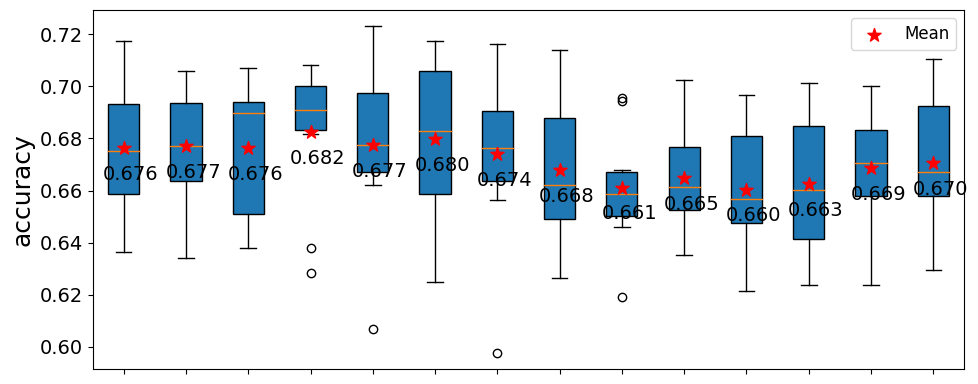

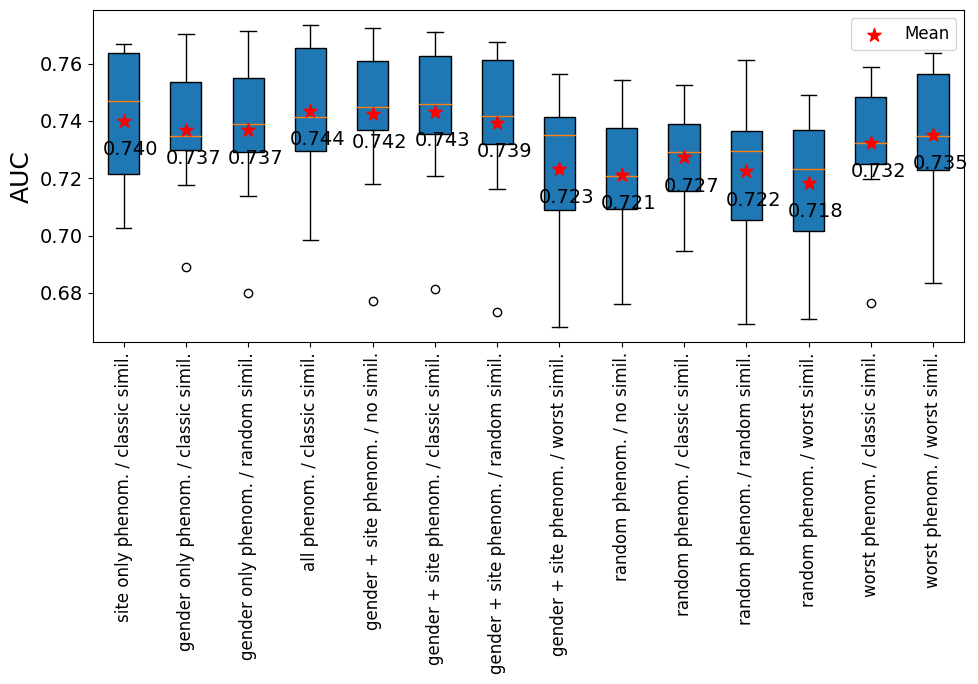

In [59]:
create_vertical_boxplots(dfs_averaged_dic_sens_adjacency_matrix, labels, colname='GCN_acc', filename="boxplots_ADJ_matrix_sensitivity_acc_vertical", y_label='accuracy', y_legnth=4, with_xlabel=False)
create_vertical_boxplots(dfs_averaged_dic_sens_adjacency_matrix, labels, colname='GCN_auc', filename="boxplots_ADJ_matrix_sensitivity_auc_vertical", y_label='AUC', y_legnth=7)

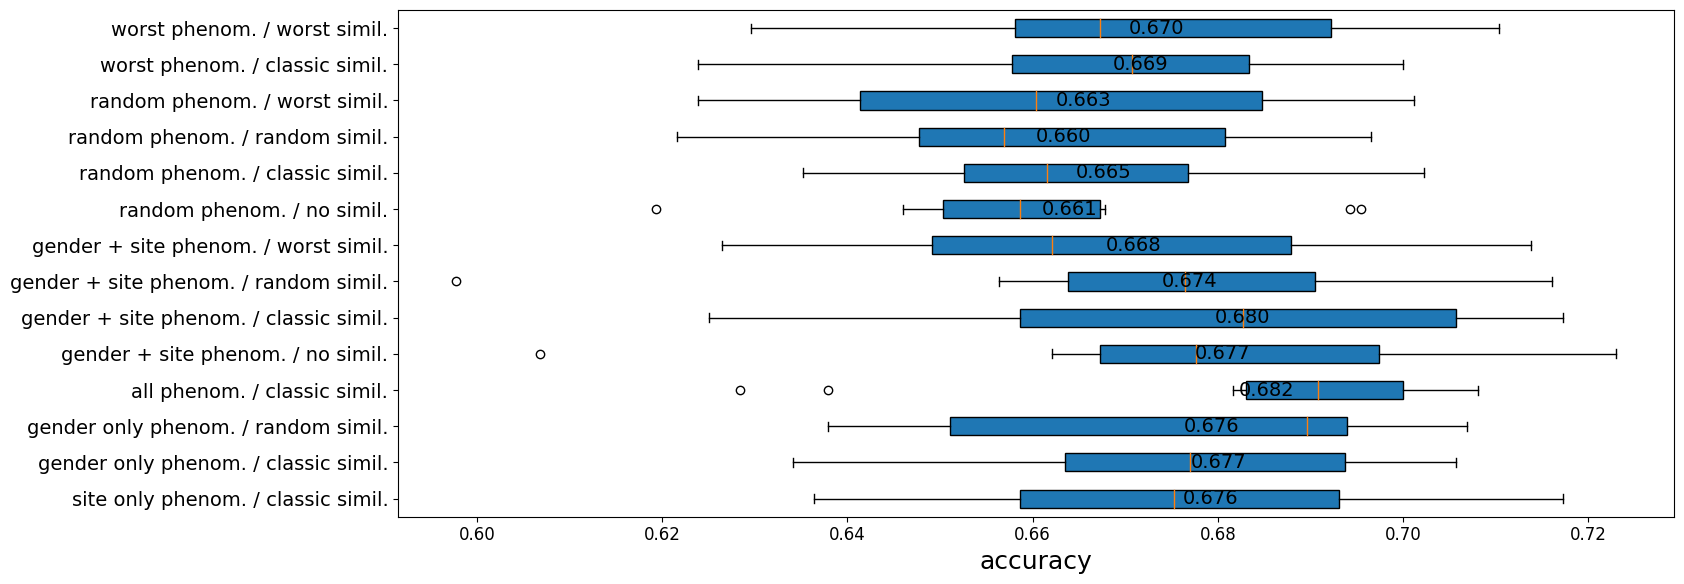

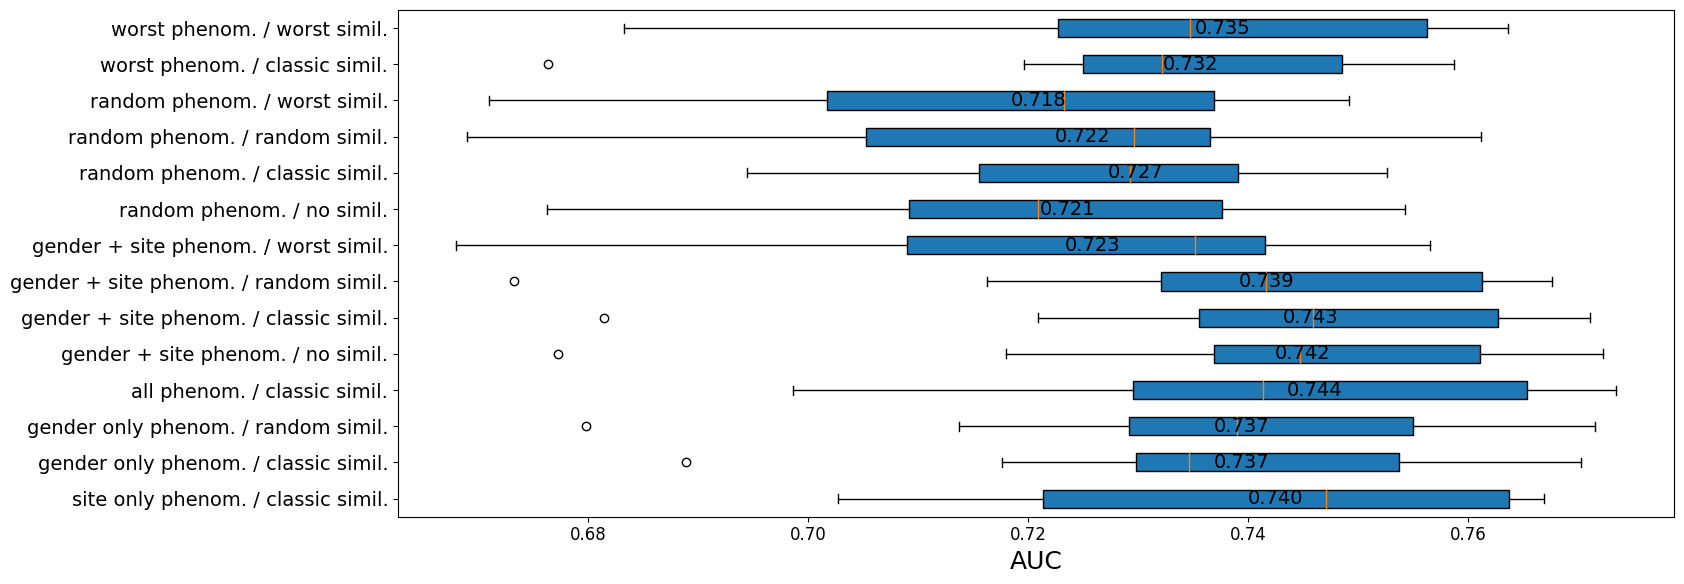

In [34]:
# Example usage:
plotting.create_horizontal_boxplots(dfs_averaged_dic_sens_adjacency_matrix, labels, colname='GCN_acc', filename="boxplots_ADJ_matrix_sensitivity_acc", x_label='accuracy')
plotting.create_horizontal_boxplots(dfs_averaged_dic_sens_adjacency_matrix, labels, colname='GCN_auc', filename="boxplots_ADJ_matrix_sensitivity_auc", x_label='AUC')

In [52]:
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.pdfgen import canvas

def generate_pdf_table(file_name, n_columns, m_rows, dfs_list, labels, colname='GCN_acc'):
    # Créer le document PDF
    # pdf = SimpleDocTemplate(file_name, pagesize=(400,250))
    # image_width, image_height = 400, 250
    # pdf = canvas.Canvas(file_name, pagesize=(image_width, image_height))
    # Generate random data for each boxplot
    data_df = [dfs_list[label][colname] for label in labels]

    # Add mean values next to each boxplot
    mean_value_dic = {}
    for i, dataset in enumerate(data_df, start=0):
        mean_value = np.mean(dataset)
        mean_value_dic[labels[i]] = mean_value

    # Générer les données du tableau
    data = [["" for j in range(n_columns)] for i in range(m_rows)]
    data[0][0] = "Phenot. type \ simil. type"

    cols_name = ['classic', 'worst', 'ones', 'random']
    for k, col in enumerate(cols_name, start=1):
        data[0][k] = col
    cols_labels_name = ['classic', 'worst', '1', 'random']
    rows_name = ['classic gender + site', 'gender only', 'site only', 'worst', 'fully connected', 'random']
    for k, row in enumerate(rows_name, start=1):
        data[k][0] = row
    rows_labels_name = ['classic', 'G', 'As', 'worst', 'all', 'random']

    for k, col in enumerate(cols_labels_name, start=1):
        for l, row in enumerate(rows_labels_name, start=1):
            if f"pheno_{row}_simi_{col}" in labels:
                data[l][k] = "{:.3f}".format(mean_value_dic[f"pheno_{row}_simi_{col}"]) 
            
    
    
    # # Créer le tableau
    # table = Table(data)

    # Style pour le tableau
    style = TableStyle([
        ('BACKGROUND', (0, 0), (-1, -1), colors.white),  # Remplissage de couleur
        ('GRID', (0, 0), (-1, -1), 1, colors.black),        # Bordures de la grille
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),              # Centrer le texte
        ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),             # Centrer verticalement
        ('TEXTCOLOR', (0, 0), (-1, -1), colors.black),   # Couleur du texte
    ])

    # table.setStyle(style)

    # # Ajouter le tableau au document
    # elements = [table]

    # # Générer le fichier PDF
    # # pdf.build(elements)
    # pdf.drawImage(elements, 0, 0, width=image_width, height=image_height)
    
    # Create a Table object
    table = Table(data)
    table.setStyle(style)
    # Get the table's width and height
    table_width, table_height = table.wrap(0, 0)

    # Create the PDF with the page size matching the table dimensions
    # file_name = "output_table_no_margins.pdf"
    c = canvas.Canvas(file_name, pagesize=(table_width, table_height))

    # Draw the table at the bottom-left corner of the page
    table.drawOn(c, 0, 0)

    # Save the PDF
    c.save()

# Paramètres pour le tableau
n_columns = 5  # Nombre de colonnes
m_rows = 7    # Nombre de lignes
file_name = "../figures/synthesis_result_ADJ_matrix_sensibility_acc.pdf"
generate_pdf_table(file_name, n_columns, m_rows, dfs_averaged_dic_sens_adjacency_matrix, labels, colname='GCN_acc')
file_name = "../figures/synthesis_result_ADJ_matrix_sensibility_auc.pdf"
generate_pdf_table(file_name, n_columns, m_rows, dfs_averaged_dic_sens_adjacency_matrix, labels, colname='GCN_auc')


### Sensitivity to the number of features selected for the RFE

In [15]:
import os

def get_key_from_folder_name(subfolder):
    params = subfolder.split('_')
    seedInit_id = None if 'seed' not in params else params[params.index('seed')+ 1]
    seedFold_id = None if 'seedF' not in params else params[params.index('seedF')+ 1]
    nb_features = None if 'seedF' not in params else params[params.index('nfeat')+ 1]

    key = f'nbFeat_{nb_features}_seedInit_{seedInit_id}_seedFold_{seedFold_id}'
    label = f'nbFeat_{nb_features}'
    return key, label

folder = '../results/nb_feats_sens/'

dfs_dic = {}
labels_list = [] 
# Parcours des sous-folders
for subfolder_name in os.listdir(folder):
    complete_path = os.path.join(folder, subfolder_name)
    if os.path.isdir(complete_path):  # Vérifie si c'est un sous-dossier
        key_subfolder, label = get_key_from_folder_name(subfolder_name)
        data_key = scipy.io.loadmat(complete_path + '/data')
        labels_list.append(label)
        # print(subfolder_name)
        data_key_df = {
            'ridge_classifier_acc': data_key['lin'].flatten(),#/100,
            'ridge_classifier_auc': data_key['lin_auc'].flatten(),
            'GCN_acc': data_key['acc'].flatten(),
            'GCN_auc': data_key['auc'].flatten(),
            'folds': data_key['folds'].flatten()
        }
        df_key_data = pd.DataFrame(data_key_df)
        utils.transform_acc_in_ratio(df_key_data)
        dfs_dic[key_subfolder] = df_key_data

labels = np.unique(np.array(labels_list))

In [21]:
dfs_averaged_dic_seens_NB_features = average_results_wrt_seed_init(labels, dfs_dic)

nb_features_array = np.array([int(ch[7:]) for ch in labels])
nb_features_array.sort()
means_acc_list = np.array([dfs_averaged_dic_seens_NB_features[f'nbFeat_{nb_feat}']['GCN_acc'].to_numpy().mean() for nb_feat in nb_features_array])


df_ridge_RFE_sensitivity = pd.read_csv('../results/linearRegression/df_ridge_RFE_sensitivity.csv')
df_ridge_RFE_sensitivity.drop(axis=1, labels="Unnamed: 0", inplace=True)
# Pivot the DataFrame
pivot_df = df_ridge_RFE_sensitivity.pivot(index='RFE_nb_components', columns='alpha', values='accuracy_mean')
# Extract grid values
alpha_unique = pivot_df.columns.values  # Columns represent unique alpha values
C_unique = pivot_df.index.values        # Rows represent unique C values
nb_features_array_ridge = C_unique[(C_unique >= nb_features_array.min() )& (C_unique<= nb_features_array.max())]
means_acc_ridge = df_ridge_RFE_sensitivity.loc[(df_ridge_RFE_sensitivity["alpha"] == 1.0) & (df_ridge_RFE_sensitivity["RFE_nb_components"] >= nb_features_array.min()) & (df_ridge_RFE_sensitivity["RFE_nb_components"] <= nb_features_array.max()), "accuracy_mean"].to_numpy()

C:\Users\33781\AppData\Local\Temp\ipykernel_14916\2991181851.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w^" (-> color='w'). The keyword argument will take precedence.
  plt.plot([2000], [means_acc_list[k_nb_features_2000]], 'w^', markersize=15, c='red', label=f"GCN accuracy")
C:\Users\33781\AppData\Local\Temp\ipykernel_14916\2991181851.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ws" (-> color='w'). The keyword argument will take precedence.
  plt.plot([2000], [means_acc_ridge[k_nb_features_2000_ridge]], 'ws', markersize=15, c='green', label=f"Ridge accuracy from Parisot's paper")


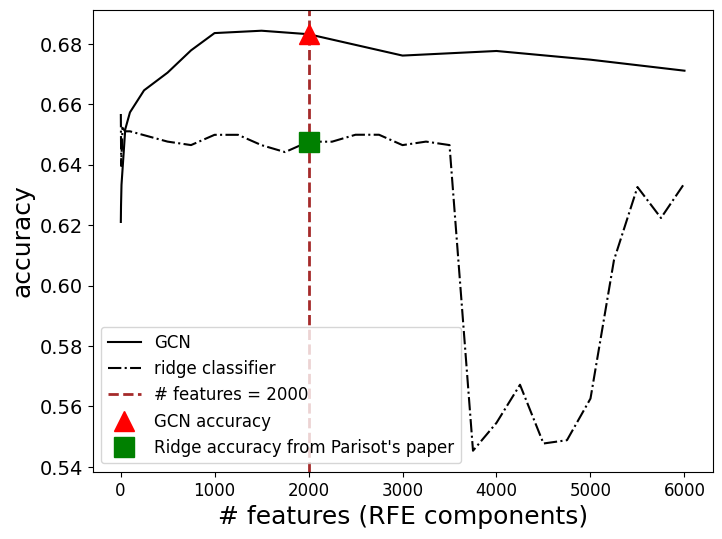

In [25]:

plt.figure(figsize=(8, 6))
plt.plot(nb_features_array, means_acc_list, c='black', label ='GCN')
plt.plot(nb_features_array_ridge, means_acc_ridge, linestyle='-.', c='black', label='ridge classifier')

k_nb_features_2000 = np.where(nb_features_array == 2000)[0].item()
k_nb_features_2000_ridge = np.where(nb_features_array_ridge == 2000)[0].item()
plt.axvline([2000], color='brown', linestyle='--', linewidth=2, label="# features = 2000")
plt.plot([2000], [means_acc_list[k_nb_features_2000]], 'w^', markersize=15, c='red', label=f"GCN accuracy")
plt.plot([2000], [means_acc_ridge[k_nb_features_2000_ridge]], 'ws', markersize=15, c='green', label=f"Ridge accuracy from Parisot's paper")
plt.xlabel('# features (RFE components)')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.savefig('../figures/sensitivity_nb_features_C.png', dpi=250)
plt.savefig('../figures/sensitivity_nb_features_C.pdf', dpi=250)

## Reproducing Fig. 2 of Parisot's paper

In [14]:
labels

array(['nbFeat_10', 'nbFeat_100', 'nbFeat_1000', 'nbFeat_1500',
       'nbFeat_2000', 'nbFeat_250', 'nbFeat_3', 'nbFeat_3000',
       'nbFeat_4000', 'nbFeat_5', 'nbFeat_50', 'nbFeat_500',
       'nbFeat_5000', 'nbFeat_6000', 'nbFeat_750'], dtype='<U11')

In [15]:
df_classic = dfs_averaged_dic_seens_NB_features['nbFeat_2000']
df_random = dfs_averaged_dic_sens_adjacency_matrix['pheno_random_simi_random']
df_classic['rd1_GCN_acc'] = df_random['GCN_acc']
df_classic['rd1_GCN_auc'] = df_random['GCN_auc']

In [16]:
def plot_acc_auc_boxplot(df_result):
    N_RD_EXP= 1
    xticks_list = np.arange(2+N_RD_EXP) + 1
    xticks_lables = ['GCN'] + ["Random Graph\nMethod"] + ['Ridge classifier']

    # Set colors for each boxplot
    colors = ['skyblue', 'lightgreen', 'lightcoral'] * 2

    # Create the first plot for lin and acc
    plt.figure(figsize=(12, 6))
    # Boxplot for lin and acc
    plt.subplot(1, 2, 1)
    Y = [df_result['GCN_acc']] + [df_result[f'rd{k+1}_GCN_acc'] for k in range(N_RD_EXP)] + [df_result['ridge_classifier_acc']]
    bp1 = plt.boxplot(Y, patch_artist=True, widths=0.5, medianprops={'color': 'black'})
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)

    # Color the boxes for the first subplot
    for patch, color in zip(bp1['boxes'], colors[:3]):
        patch.set_facecolor(color)

    # Add red square for the mean
    for i, median in enumerate(bp1['medians']):
        median_value = median.get_ydata()[0]
        plt.scatter(i+1, median_value, color='red', marker='s', zorder=5)

    # Set titles and labels
    plt.title('ABIDE accuracy')
    plt.xticks(xticks_list, xticks_lables, fontsize=15)

    # Create the second plot for lin_auc and auc
    plt.subplot(1, 2, 2)
    Y = [df_result['GCN_auc']] + [df_result[f'rd{k+1}_GCN_auc'] for k in range(N_RD_EXP)] + [df_result['ridge_classifier_auc']]
    bp2 = plt.boxplot(Y, patch_artist=True, widths=0.5, medianprops={'color': 'black'})
    plt.grid(axis='y', linestyle='--', color='gray', alpha=0.7)

    # Color the boxes for the second subplot
    for patch, color in zip(bp2['boxes'], colors[3:]):
        patch.set_facecolor(color)

    # Add red square for the mean
    for i, median in enumerate(bp2['medians']):
        median_value = median.get_ydata()[0]
        plt.scatter(i+1, median_value, color='red', marker='s', zorder=5)

    # Set titles and labels
    plt.title('ABIDE AUC')
    plt.xticks(xticks_list, xticks_lables, fontsize=15)

    # Adjust layout to avoid overlap
    plt.tight_layout()

    # Show the plots
    plt.savefig(f"../figures/figure2_paper_reproduced.png", dpi=250)
    plt.savefig(f"../figures/figure2_paper_reproduced.pdf", dpi=250)

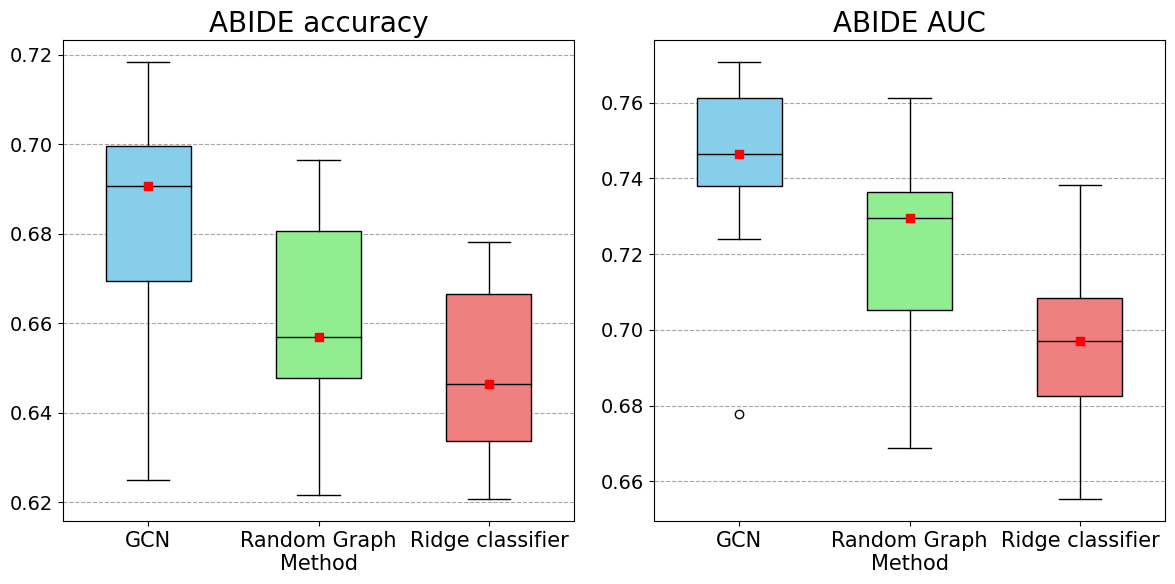

In [17]:
plot_acc_auc_boxplot(df_classic)